### Coursework 1

In this coursework you will be aiming to complete two classification tasks. One of the classification tasks is related to image classification and the other relates to text classification.

The specific tasks and the marking for the various tasks are provided in the notebook. Each task is expected to be accompanied by a lab-report. Each task can have a concise lab report that is maximum of one page in an A4 size. You will be expected to submit your Jupyter Notebook and all lab reports as a single PDF file. You could have additional functions implemented that you require for carrying out each task.

#### Task 1

In this task, you are provided with three classes of images, cars, bikes and people in real world settings. You are provided with code for obtaining features for these images (specifically histogram of gradients (HoG) features). You need to implement a boosting based classifier that can be used to classify the images. 

This task is worth 30 points out of 100 points. 
Implementing a working boosting based classifier and validating it by cross-validation on the training set will be evaluated for 15 out of 30 points. 10 points are based on the evaluation carried out on a separate test dataset that will be done at the time of evaluation. Finally 5 points are reserved for analysis of this part of the task and presenting it well in a lab report. 

Note that the boosting classifier you implement can include decision trees from your previous ML1 coursework or can be a decision stump. Use the image_dataset directory provided with the assignment and save it in the same directory as the Python notebook

#### Write your  Image feature extraction code

In [1]:
import numpy as np
import cv2 as cv
import glob
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import os
from tqdm import tqdm
import time
import matplotlib.pyplot as plt    
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.rcParams['figure.figsize'] = [10, 6]
from IPython.display import clear_output

In [2]:
    
def obtain_dataset(folder_name, 
                   include_augmented = True, 
                   Hog_features = True):
    feature_len = 34020
    hog = cv.HOGDescriptor()

    y = []
    X = []

    c = 0
    
    # store images to visualize if necessary
    image_dict = {}
    
    class_dict = {'bike'    : 1, 
                  'car'     : 2, 
                  'people'  : 3} 
    
    for subdir, dirs, files in os.walk(folder_name):
        for file in files:
            
            if not include_augmented: 
                if 'aug' in file:
                    file = ''
            
            # get file location from directory
            file_location = subdir + "\\" + file
            
            try:
                img = cv.imread(file_location)
                image_dict.update({file:img})
                h = hog.compute(img)
                
                if Hog_features:
                    X.append(h)
                else:
                    X.append([img])
                
                if 'bike' in file:
                    y.append(class_dict['bike'])
                elif 'car' in file:
                    y.append(class_dict['car'])
                elif 'person' in file:
                    y.append(class_dict['people'])
                else:
                    y.append(np.nan)
                    
            except:
                print('Error when loading file : ', file)
    if Hog_features:
        X = np.concatenate(X, axis = 1).T
    print('Data Loaded.')
    return X, y



## Decision Tree Class

In [3]:
class Decision_Tree:
    
    def __init__(self, x, y, 
                 start_feature,
                 num_features, 
                 min_leaf, 
                 max_depth):
        
        self.features = np.arange(start_feature, start_feature + num_features)
        
        # init data
        self.x = x #x.iloc[:,self.features].values
        self.y = y #y.values
        self.num_rows = x.shape[0]
        
        # init hyperparameters
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        
        # data charactersitics
        self.num_features = num_features 
        self.val = np.mean(y)
        
        self.score = np.inf
        
        self.tree = self.build_tree(self.x, self.y, max_depth)
        
    def calculate_entropy(self,y):

        prob = pd.Series(y).value_counts(normalize = True) 
        return - np.sum(prob * np.log(prob)) / np.log(2)
    
    def find_split(self, x, y):
        """Given a dataset and its target values, this finds the optimal combination
        of feature and split point that gives the maximum information gain."""

        # Need the starting entropy so we can measure improvement...
        start_entropy = self.calculate_entropy(y)

        # all possible indices
        indices = np.arange( len(x) )

        # Best thus far, initialised to a dud that will be replaced immediately...
        best = {'infogain' : -np.inf}

        # Loop every possible split of every dimension...
        for i in range(x.shape[1]):
            for split in np.unique(x[:,i]):
                
                
                # indices that are greater than or less than split value
                left_indices  = indices[x[:,i] <= split]
                right_indices = indices[x[:,i] >  split]

                left_ratio = ( len(left_indices) / len(x) ) 
                right_ratio = ( len(right_indices) / len(x) ) 

                infogain = start_entropy - left_ratio \
                                        * self.calculate_entropy( y[left_indices] ) - \
                                        right_ratio * self.calculate_entropy( y[right_indices] )

                # update dictionary with optimal values
                if infogain > best['infogain']:
                    best = {'feature' : i,
                            'split' : split,
                            'infogain' : infogain, 
                            'left_indices' : left_indices,
                            'right_indices' : right_indices}

        return best
    
    def build_tree(self, x, y, max_depth = np.inf):

        # Check if either of the stopping conditions have been reached. If so generate a leaf node...
        if max_depth == 1 or (y == y[0]).all():
            # Generate a leaf node...
            classes, counts = np.unique(y, return_counts=True)
            return {'leaf' : True, 'class' : classes[np.argmax(counts)]}

        else:
            move = self.find_split(x, y)

            left = self.build_tree(x[move['left_indices'],:], y[move['left_indices']], max_depth - 1)
            right = self.build_tree(x[move['right_indices'],:], y[move['right_indices']], max_depth - 1)

            return {'leaf' : False,
                    'feature' : move['feature'],
                    'split' : move['split'],
                    'infogain' : move['infogain'],
                    'left' : left,
                    'right' : right}
        
    def predict_one(self, tree, sample):
        """Does the prediction for a single data point"""
        if tree['leaf']:
            return tree['class']

        else:
            if sample[tree['feature']] <= tree['split']:
                return self.predict_one(tree['left'], sample)
            else:
                return self.predict_one(tree['right'], sample)

    def predict(self, x_test):
        """Predicts class for every entry of a data matrix."""
        
        samples = x_test #.iloc[:,self.features].values
        
        ret = np.empty(samples.shape[0], dtype=int)
        ret.fill(-1)
        indices = np.arange(samples.shape[0])

        def tranverse(node, indices):
            nonlocal samples
            nonlocal ret

            if node['leaf']:
                ret[indices] = node['class']

            else:
                going_left = samples[indices, node['feature']] <= node['split']
                left_indices = indices[going_left]
                right_indices = indices[np.logical_not(going_left)]

                if left_indices.shape[0] > 0:
                    tranverse(node['left'], left_indices)

                if right_indices.shape[0] > 0:
                    tranverse(node['right'], right_indices)

        tranverse(self.tree, indices)
        return ret

#### Boosting classifier class

In [4]:
class BoostingClassifier:
    
    def __init__(self,n_estimators = 10,
                 max_depth = 5,
                 num_features = 1000,
                 start_feature = 200, 
                 sklearn = True):
        
        self.sklearn = sklearn
        
        self.n_est = n_estimators
        self.depth = max_depth
        
        self.trees = []
        self.tree_weights = []
        
        self.num_features = num_features
        self.start = start_feature
        
    def update_weights(self, weights, y, y_dt, tree_weights):
        
        for i in range(weights.shape[0]):
            if y[i] != y_dt[i]:
                weights[i] = weights[i]*np.exp(tree_weights)
        
        weights /= np.sum(weights)
        return weights
        
    def fit(self, X, y):
        
        n_class = np.unique(y).shape[0]
        
        # init weights, value is aribitrary
        weights = np.array([1/X.shape[0] for i in range(X.shape[0])])
        weights = weights.reshape([-1,1])
        
        start = self.start 
        features = np.arange(start , start + self.num_features)   
        
        for i in tqdm(range(self.n_est)):
            if self.sklearn == False:
                # instantiate DT & fit to data
                DT = Decision_Tree(X, y,
                      num_features = self.num_features,
                      max_depth = self.depth,
                      start_feature = self.start)
            elif self.sklearn == True:
                DT = DecisionTreeClassifier(max_depth = self.depth)
                DT.fit(X,y)
            
            # predict with trees
            dt_pred = DT.predict(X)
            
            # update tree weights
            error = np.sum(weights[np.where(y != dt_pred)])
            self.tree_weights.append(np.log((1 - error) / error) \
                                     + np.log(n_class - 1))
            
            # update data weights
            weights = self.update_weights(weights, 
                                          y, 
                                          dt_pred, 
                                          self.tree_weights[-1])
            # store each tree
            self.trees.append(DT)
            
    
    def predict(self, X):
        
        n = X.shape[0]
        
        pred = np.array([tree.predict(X) for tree in self.trees]).T
        
        y_pred = []
        for i in range(n):
            
            current = pred[i,:]
            class_weights = {prediction : 0 for prediction in np.unique(current)}
            for j, prediction in enumerate(current):
                class_weights[prediction] += self.tree_weights[j]
                
            optimal_weight = max(class_weights, key = class_weights.get)
            y_pred.append(optimal_weight)
            
        return np.array(y_pred)

#### define train test split function & normilization functions

In [5]:
def train_test_valid(df, train_ratio = 0.6, valid_ratio = 0.2 ):
    
    train, validation, test = np.split(df.sample(frac = 1, 
                                                 random_state = np.random.randint(1,1e3)), 
                                       [int(train_ratio * len(df)), 
                                        int((train_ratio + valid_ratio) * len(df))])
    
    return train, test, validation

# function for normalizing data
def normalize(df, mean_method = True ):
    if mean_method:
        # mean normalization
        normalized_df = (df - df.mean()) / df.std()
        a, b = df.std(), df.mean()
    else:
        # min max normalization
        normalized_df = (df - df.min()) / (df.max() - df.min())
        a, b = df.min(), df.max()
    return normalized_df, a, b

def unnormalize(df, a, b, mean_method = True):
    if mean_method:
        # mean normalization
        unnormalized_df = df * a + b
    else:
        # min max normalization
        unnormalized_df = (df * (b - a)) + a
    return unnormalized_df

## Option to download augmented images to image folder

In [6]:
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img

datagen = ImageDataGenerator( 
        rotation_range = 40, 
        shear_range = 0.2, 
        zoom_range = 0.2, 
        horizontal_flip = True, 
        brightness_range = (0.5, 1.5))

def augment_images(image_name, fname, directory):
    img = load_img(image_name)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    for batch in datagen.flow(x, batch_size = 1,
                     save_to_dir = directory,
                     save_prefix = fname, 
                     save_format = 'png'):
        i += 1
        if i >= 5:
            break


perform_augmentation = False
if perform_augmentation:
    folder_name = 'image_dataset'
    for subdir, dirs, files in os.walk(folder_name):
            for file in files:

                # get file location from directory
                file_location = subdir + "\\" + file

                if 'bike' in file:
                    fname = 'bike_aug'
                elif 'car' in file:
                    fname = 'car_aug'
                elif 'person' in file:
                    fname = 'person_aug'
                else:
                    y.append(np.nan)

                if 'img' in file: # only augment OG images
                    augment_images(file_location, fname, subdir)

## Image augmentation and HOG feature extraction function

In [7]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
def HOG_augment(df, augment = True, n = 2):
    
    datagen = ImageDataGenerator( 
            rotation_range = 40, 
            shear_range = 0.2, 
            zoom_range = 0.2, 
            horizontal_flip = True, 
            brightness_range = (0.5, 1.5))
    
    hog = cv.HOGDescriptor()
    
    x = []
    y = []
    
    
    
    for image, target in tqdm(df.values):
        
        # get hog features for OG images
        x.append(hog.compute(image))
        y.append(target)
        
        x_array = img_to_array(image)
        x_array = x_array.reshape((1,) + x_array.shape)
        
        if augment:
            i = 0
            for batch in datagen.flow(x_array):

                b = np.asarray(array_to_img(np.squeeze(batch)))
                h = hog.compute(b)

                # save hog features and class for augmented images
                x.append(h)
                y.append(target)

                i+=1
                if i >= n:
                    break
                
                
    X = np.hstack(x).T 
    
    df_augmented = pd.DataFrame(X)
    df_augmented['y'] = y
    
    return df_augmented


### principal component analysis for dimensionality reduction

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

def reduce_features(df, num_features = 20, solver = 'full'):
    
    encoder = LabelEncoder()
    
    # split input and target 
    x, y = df.iloc[:,:-1], df.iloc[:,-1]
    
    for col in tqdm(x.columns[:]):
        x[col] = encoder.fit_transform(x[col])
    
    # apply scaler to input features
    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    # transform features
    pca = PCA(svd_solver = solver)
    pca.fit_transform(x)
    pca_variance = pca.explained_variance_
    
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    
    # fit
    pca2 = PCA(n_components = num_features, whiten = True)
    pca2.fit(x)
    pca_x = pca2.transform(x)

    # recreate dataframe after PCA
    df_pca = pd.DataFrame(pca_x)
    df_pca['y'] = y.values
    
    return df_pca

In [9]:
folder_name = 'image_dataset'
x, y = obtain_dataset(folder_name, 
                   include_augmented = True, 
                   Hog_features = False)

df = pd.DataFrame(x)
df['y'] = y

Error when loading file :  .DS_Store
Error when loading file :  reports.docx
Data Loaded.


100%|██████████| 34020/34020 [16:28<00:00, 34.43it/s] 


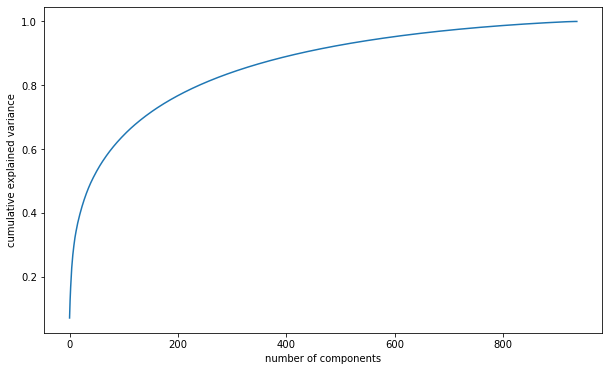

In [10]:
df_hog = HOG_augment(df, augment = False)
df_pca = reduce_features(df_hog, num_features = 125)

In [11]:
# random split for test and training set
train1, test1, val1 = train_test_valid(df_pca,
                                   train_ratio = 0.8,
                                   valid_ratio = 0.0)

In [12]:
# random split for test and training set
train, test, val = train_test_valid(df,
                                   train_ratio = 0.8,
                                   valid_ratio = 0.0)

In [13]:
train = HOG_augment(train, augment = False, n = 0)
test = HOG_augment(test, augment = False)

100%|██████████| 188/188 [00:00<00:00, 2326.65it/s]


100%|██████████| 34020/34020 [03:45<00:00, 150.57it/s] 


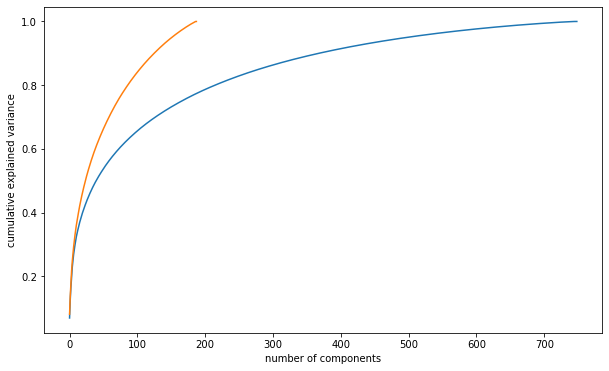

In [14]:
train = reduce_features(train, num_features = 30, solver = 'auto')
test = reduce_features(test, num_features = 30, solver = 'auto')

In [15]:
# seperate input X from target variable y
x_train, y_train = train1.iloc[:,:-1], train1.iloc[:,-1]
x_test, y_test = test1.iloc[:,:-1], test1.iloc[:,-1]

# normalize test and train data
x_train, x_test = normalize(x_train)[0], normalize(x_test)[0]

In [16]:
DT = DecisionTreeClassifier(max_depth = 1000)
DT.fit(x_train, y_train)
y_pred = DT.predict(x_test)
print('accuracy: ', accuracy_score(y_test, y_pred))

accuracy:  0.4787234042553192


#### Train the boosting classifer and evaluate it on the train-test split

In [17]:
bc = BoostingClassifier(n_estimators = 100,
                 max_depth = 10,
                 sklearn = True)

bc.fit(x_train.values, y_train.values)

y_pred = bc.predict(x_test.values)
print('accuracy: ', accuracy_score(y_test, y_pred))

100%|██████████| 100/100 [00:04<00:00, 23.15it/s]

accuracy:  0.526595744680851


In [18]:
from sklearn.ensemble import AdaBoostClassifier as boost

bc = boost(n_estimators = 50)

bc.fit(x_train,y_train)

y_pred = bc.predict(x_test.values)
print('accuracy: ', accuracy_score(y_test, y_pred))

accuracy:  0.526595744680851


## Define multiclass ROC curve function

In [19]:
from sklearn import metrics
def plot_multiclass_roc(clf, X_test, y_test, classes = [], figsize=(14, 8)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(classes)
    
    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', size = 25)
    ax.set_ylabel('True Positive Rate', size = 25)
    plt.tick_params(axis='x', which='major', labelsize=20)
    plt.tick_params(axis='y', which='major', labelsize=20)
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='AUC = {:0.2f} for {}'.format(roc_auc[i], classes[i]))
    ax.legend(loc="best", fontsize = 20)
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

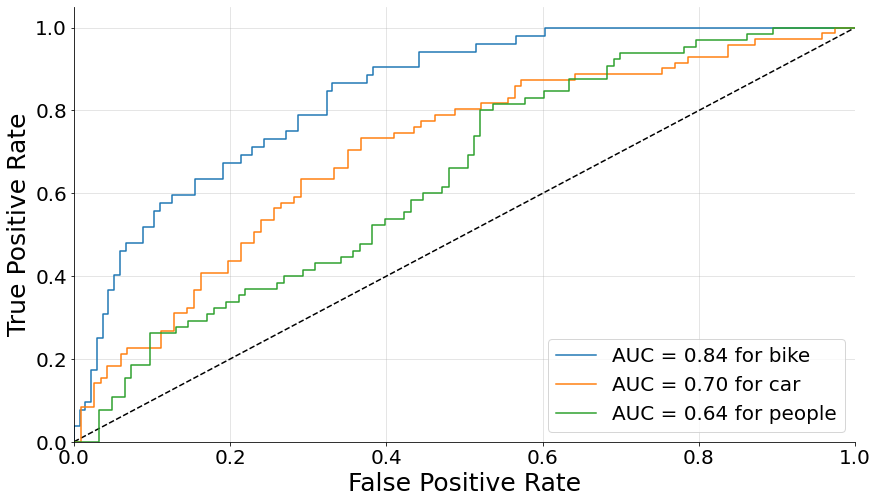

In [20]:
plot_multiclass_roc(bc, x_test, y_test, 
                    classes = ['bike', 'car', 'people'])

## Define Cross validation function

In [21]:
def kfoldCV(df, kfolds = 5, norm = True, model_type = 'boosting',
           sklearn = True,
           n_est = 100,
           depth = 5,
           k = 'exponential',
           reg = 1,
           deg = 3):
    
    
    # get K folds
    folds = np.array_split(df.sample(frac = 1, random_state = np.random.randint(0,1000)), kfolds)
    
    scores = []
    for i in range(kfolds):
        clear_output(wait=True)
        print('Fold: ', i)
        # set test set to current fold
        test = folds[i]
        
        # train on remaining folds combined
        train = folds.copy() 
        del train[i] #remove current fold
        df_train = pd.DataFrame(np.vstack(train))
        
        # seperate input and target variable
        x_train, y_train = df_train.iloc[:,:-1], df_train.iloc[:,-1]
        x_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]
        
        if norm:
            # normalize test and train data
            x_train, x_test = normalize(x_train)[0], normalize(x_test)[0]
        
        if model_type == 'boosting':
            model = BoostingClassifier(n_estimators = n_est,
                                     max_depth = depth,
                                     sklearn = sklearn)
        elif model_type == 'svm':
            model = SVMClassifier(kernel = k,
                               reg_param = reg,
                               degree = deg)
            
        # fit model to training data and predict on test data
        model.fit(x_train.values, y_train.values)
        y_pred = model.predict(x_test.values)

        # store accuracy data
        scores.append(accuracy_score(y_test, y_pred))
    
    return scores

# Average Score from Cross Validation

In [22]:
scores = kfoldCV(df_pca, kfolds = 5, 
                       model_type = 'boosting',
                       n_est = 100,
                       depth = 5)

print('Average score from Cross Validation: {:.2f}'.format(np.mean(scores)))

  0%|          | 0/100 [00:00<?, ?it/s]

Fold:  4


100%|██████████| 100/100 [00:02<00:00, 33.74it/s]

Average score from Cross Validation: 0.48


In [23]:
bc = BoostingClassifier(n_estimators = 100,
                 max_depth = 5,
                 sklearn = True)

bc.fit(x_train.values, y_train.values)

y_pred = bc.predict(x_test.values)
print('accuracy: ', accuracy_score(y_test, y_pred))

100%|██████████| 100/100 [00:02<00:00, 34.26it/s]

accuracy:  0.5106382978723404


[Text(0.5, 0, 'Bike'), Text(1.5, 0, 'Car'), Text(2.5, 0, 'Person')]

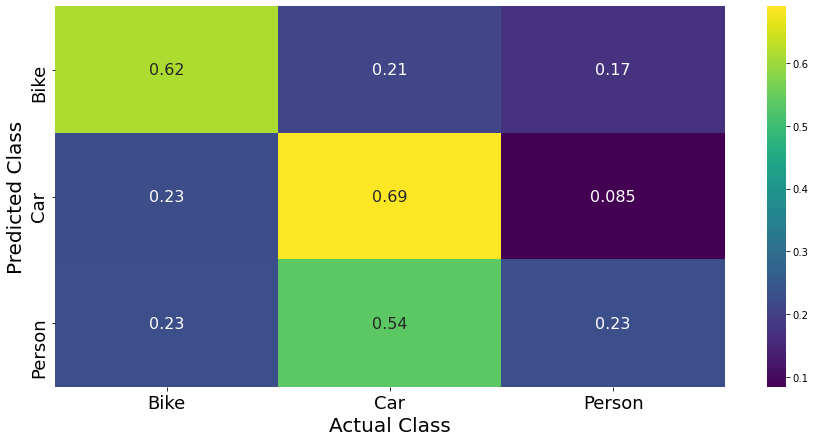

In [24]:
plt.rcParams['figure.figsize'] = [15, 7]
res = sns.heatmap(confusion_matrix(y_test,y_pred, normalize = 'true'), 
            annot = True, 
            xticklabels = ['Bike', 'Car', 'Person'],
            yticklabels = ['Bike', 'Car', 'Person'],
            cmap = 'viridis', annot_kws={"size": 16})

plt.xlabel('Actual Class', size = 20)
plt.ylabel('Predicted Class', size = 20)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)

#### Task 2

In this task, you need to classify the above dataset using a Support Vector Machine (SVM).

This task is worth 25 points out of 100 points. You are allowed to use existing library functions such as scikit-learn for obtaining the SVM. The main idea is to analyse the dataset using different kind of kernels. You are also supposed to write your own custom kernels. The marking will be 15 marks for analysing the dataset using various kernels including your own kernels, 5 points for the performance on the test dataset and 5 points for a lab-report that provides the analysis and comparisons.

## SVM class w/ custom kernels

In [25]:
from sklearn import svm
class SVMClassifier:
    
    def __init__(self, kernel = 'exponential',
                       reg_param = 1.0,
                       degree = 3,
                       max_iter = 1e5,
                       tol = 1e-3):
        
        
        if kernel == 'sigmoid':
            k = self.sigmoid
        elif kernel == 'linear':
            k = self.linear
        elif kernel == 'poly':
            k = self.polynomial
        elif kernel == 'gaussian':
            k = self.gaussian
        elif kernel == 'laplacian':
            k = self.laplacian
        elif kernel == 'log':
            k = self.log
        elif kernel == 'exponential':
            k = self.exponential
        elif kernel == 'rational':
            k = self.rational
        elif kernel == 'quadric':
            k = self.quadric
        elif kernel == 'rbf':
            k = kernel
        elif kernel == 'linear_sklearn':
            k = 'linear'
        elif kernel == 'poly_sklearn':
            k = 'poly'
        elif kernel == 'intersection':
            k = self.intersect
        else:
            print('Using externel kernel.')
            k = kernel
            #return
        
        # instantial svm classifier
        self.clf = svm.SVC(C = reg_param,
              kernel = k,
              degree = degree,
              gamma = 'scale')
        
    def kernels_list(self):
        return ['sigmoid', 'linear', 'poly', 'gaussian', 'laplacian', 
                'log', 'exponential', 'rational', 'quadric', 'rbf', 
                'linear_sklearn', 'poly_sklearn']
    
    def linear(self, x,y):
        return np.inner(x,y)
    
    def sigmoid(self, x,y, alpha = 1):
        return np.tanh(alpha*np.inner(x,y))
    
    def polynomial(self, x,y, coef = 1, p = 6):
        return (np.inner(x,y) + coef) ** p
        
    def gaussian(self, U,V,sigma = 0.1):
        def gaussianKernel(U,V,sigma = 0.1):
            return np.exp(np.linalg.norm(U-V) ** 2 / (2*sigma**2))

        G = np.zeros((U.shape[0], V.shape[0]))
        for i in range(0,U.shape[0]):
            for j in range(0,V.shape[0]):
                G[i][j] = gaussianKernel(U[i],V[j],sigma)
        return G    
    
    def laplacian(self, U,V,sigma = 0.1):
        def LaplacianKernel(U,V,sigma = 0.1):
            return np.exp(-np.linalg.norm(U-V) / sigma)

        G = np.zeros((U.shape[0], V.shape[0]))
        for i in range(0,U.shape[0]):
            for j in range(0,V.shape[0]):
                G[i][j] = LaplacianKernel(U[i],V[j],sigma)
        return G
    
    def log(self, U,V):
        def logKernel(U,V):
            return -np.log(np.linalg.norm(U-V) + 1)
        
        G = np.zeros((U.shape[0], V.shape[0]))
        for i in range(0,U.shape[0]):
            for j in range(0,V.shape[0]):
                G[i][j] = logKernel(U[i],V[j])
        return G
    
    def exponential(self, U,V,sigma = 0.1):
        def expKernel(U,V,sigma = 0.1):
            return - np.linalg.norm(U-V) /  (2*sigma**2) 
        G = np.zeros((U.shape[0], V.shape[0]))
        for i in range(0,U.shape[0]):
            for j in range(0,V.shape[0]):
                G[i][j] = expKernel(U[i],V[j],sigma)
        return G
    
    def rational(self, U,V,c = 100):
        def RationalKernel(U,V,c = 100):
            return 1 - (np.linalg.norm(U-V)**2 / (np.linalg.norm(U-V)**2 + c))

        G = np.zeros((U.shape[0], V.shape[0]))
        for i in range(0,U.shape[0]):
            for j in range(0,V.shape[0]):
                G[i][j] = RationalKernel(U[i],V[j],c)
        return G
    
    def quadric(self, U,V,c = 100):
        def quadricKernel(U,V,c = 100):
            return np.sqrt(np.sum(np.power((U-V),2)) + c**2)

        G = np.zeros((U.shape[0], V.shape[0]))
        for i in range(0,U.shape[0]):
            for j in range(0,V.shape[0]):
                G[i][j] = quadricKernel(U[i],V[j],c)
        return G
    
    def intersect(self, U,V,sigma = 0.1):
        def Kernel(U,V,sigma = 0.1):
            return  np.sum((min(U),  min(V)), axis = 0)
        G = np.zeros((U.shape[0], V.shape[0]))
        for i in range(0,U.shape[0]):
            for j in range(0,V.shape[0]):
                G[i][j] = Kernel(U[i],V[j],sigma)
        return G
    
    def fit(self, X,y):
        self.clf.fit(X,y)
    
    def fit_image(self, X,y):
        self.clf.fit(X,y)
    
    def fit_text(self, X,y):
        
        self.clf.fit(X,y)
    
    def predict(self, X):
        y_pred = self.clf.predict(X)
        return y_pred
    
    def predict_image(self, X):
        y_pred = self.clf.predict(X)
        return y_pred
    
    def predict_text(self, X):
        y_pred = self.clf.predict(X)
        return y_pred

#### Train the SVM classifer and evaluate it on the train-test split

In [26]:
sc = SVMClassifier(kernel = 'rbf',
                   reg_param = 1,
                   degree = 3)

sc.fit_image(x_train.values, y_train.values)
y_pred = sc.predict_image(x_test.values)
print('accuracy', accuracy_score(y_test, y_pred))

accuracy 0.6436170212765957


[Text(0.5, 0, 'Bike'), Text(1.5, 0, 'Car'), Text(2.5, 0, 'Person')]

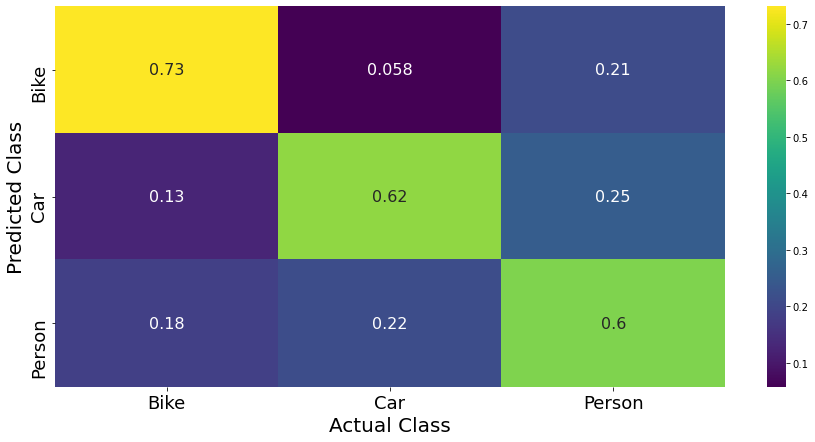

In [27]:
plt.rcParams['figure.figsize'] = [15, 7]
res = sns.heatmap(confusion_matrix(y_test,y_pred, normalize = 'true'), 
            annot = True, 
            xticklabels = ['Bike', 'Car', 'Person'],
            yticklabels = ['Bike', 'Car', 'Person'],
            cmap = 'viridis', annot_kws={"size": 16})

plt.xlabel('Actual Class', size = 20)
plt.ylabel('Predicted Class', size = 20)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)

# Score with 5-fold Cross Validation

In [28]:
scores = kfoldCV(df_pca, kfolds = 5, model_type = 'svm',
                   k = 'exponential',
                   reg = 1,
                   deg = 3)

print('Average score from Cross Validation: {:.2f}'.format(np.mean(scores)))

Fold:  4
Average score from Cross Validation: 0.65


In [29]:
clf = svm.SVC(C = 2,
              kernel = 'rbf',
              degree = 3,
              gamma = 'scale')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print('accuracy: ', accuracy_score(y_test, y_pred))

accuracy:  0.648936170212766


In [30]:
from sklearn import metrics

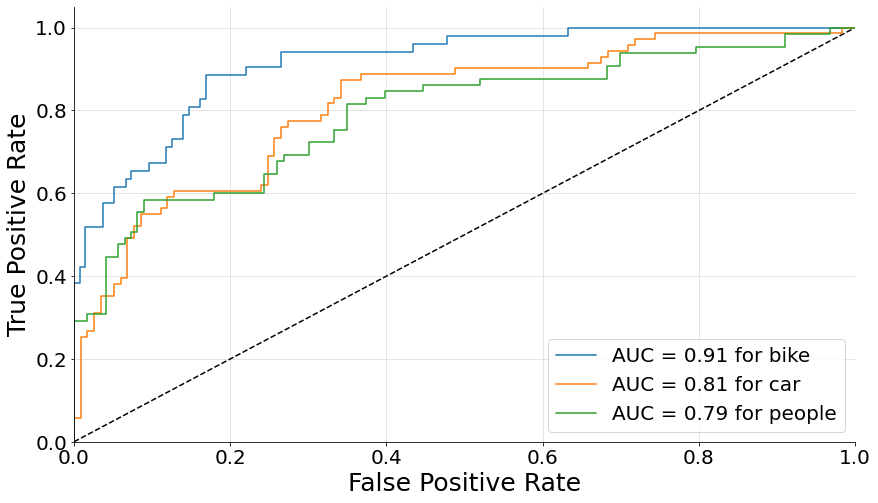

In [31]:
plot_multiclass_roc(clf, x_test, y_test, 
                    classes = ['bike', 'car', 'people'])

## Evaluate each custom kernel

In [32]:
accuracy = []

for k in sc.kernels_list():
    print(k)
    sc = SVMClassifier(kernel = k,
                   reg_param = 1,
                   degree = 3)

    sc.fit_image(x_train.values, y_train.values)
    y_pred = sc.predict_image(x_test.values)
    accuracy.append(accuracy_score(y_test, y_pred))
    clear_output(wait=True)


poly_sklearn


# Comparing Custom SVM Kernels

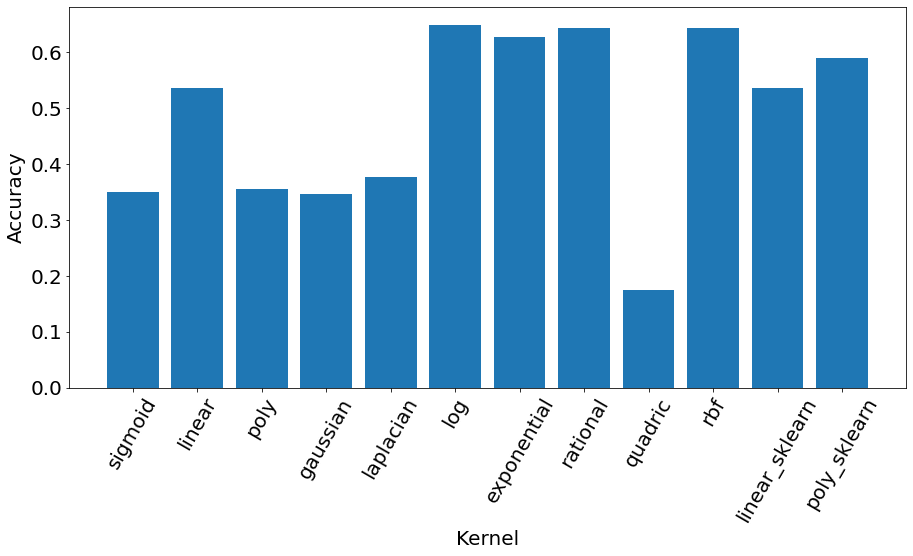

In [33]:
res = plt.bar(sc.kernels_list(), accuracy)
plt.xlabel('Kernel', size = 20)
plt.ylabel('Accuracy', size = 20)
plt.tick_params(axis='x', which='major', labelsize=20, rotation = 60)
plt.tick_params(axis='y', which='major', labelsize=20)

#### Task 3

In this task, you need to obtain sentiment analysis for the provided dataset. The dataset consists of movie reviews with the sentiments being provided. The sentiments are either positive or negative. You need to train a boosting based classifier to obtain train and cross-validate on the dataset provided. The method will be evaluated against an external test set.

This task is worth 25 points out of 100 points. 15 points will be for implementing the pre-processing and Bag of Words based feature extractor correctly and evaluating the boosting based classifier for the text features and validating it by cross-validation on the training set. 5 points are based on the evaluation carried out on a separate test dataset that will be done at the time of evaluation. Finally 5 points are reserved for analysis of this part of the task and presenting it well in a lab report.

Use the movie_review_train.csv file provided with the assignment, and save it in the same directory as the Python notebook

#### Process the text and obtain a bag of words-based features 

In [34]:
# load csv file
df_movies = pd.read_csv('movie_review_train.csv')

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 

In [35]:
def extract_bag_of_words(df, 
                         max_features = 1000, 
                         min_df = 0.05):

    vectorizer = CountVectorizer(stop_words = 'english', 
                                 min_df = min_df,
                                 max_features = int(max_features))
    x = vectorizer.fit_transform(df.iloc[:,-2])

    transformer = TfidfTransformer()
    tf = transformer.fit_transform(x)

    df_tf = pd.DataFrame(tf.toarray())
    df_tf['y'] = df.iloc[:,-1]
    df_tf['y'].replace('positive', 1, inplace = True)
    df_tf['y'].replace('negative', 0, inplace = True)
    
    return df_tf

In [36]:
# extract features from documents / reviews in dataset
df_tf = extract_bag_of_words(df_movies,
                             max_features = 1e4,
                             min_df = .005) # minimum allowable document frequency

  0%|          | 0/3011 [00:00<?, ?it/s]<ipython-input-8-e4e3b2f1243c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[col] = encoder.fit_transform(x[col])
100%|██████████| 3011/3011 [01:09<00:00, 43.19it/s] 


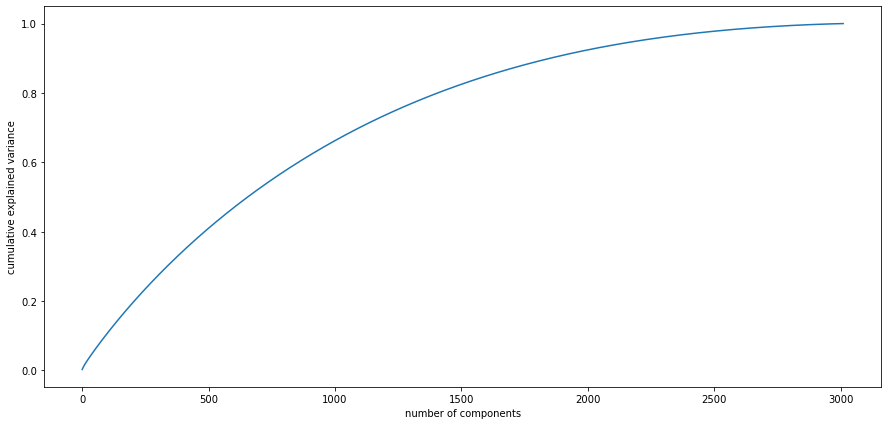

In [37]:
# dimensionality reduction with pca
df_pca = reduce_features(df_tf, num_features = 100)

In [38]:
# random split for test and training set
train, test, val = train_test_valid(df_pca,
                                   train_ratio = 0.8,
                                   valid_ratio = 0.0)

# seperate input X from target variable y
x_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
x_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

In [39]:
# instantiate, fit, and predict with boosting classifier
bc = BoostingClassifier(n_estimators = 100,
                        max_depth = 5, 
                        sklearn = True)
bc.fit(x_train.values, y_train.values)

y_pred = bc.predict(x_test.values)
print('accuracy: ', accuracy_score(y_test, y_pred))

100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


accuracy:  0.781


# Cross Validation

In [40]:
# 5 fold cross validation on boosting estimator
scores = kfoldCV(df_pca, kfolds = 5, model_type = 'boosting',
                       n_est = 100,
                       depth = 5)

print('Average score from Cross Validation: {:.2f}'.format(np.mean(scores)))

  0%|          | 0/100 [00:00<?, ?it/s]

Fold:  4


100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Average score from Cross Validation: 0.77


[Text(0.5, 0, 'Positive'), Text(1.5, 0, 'Negative')]

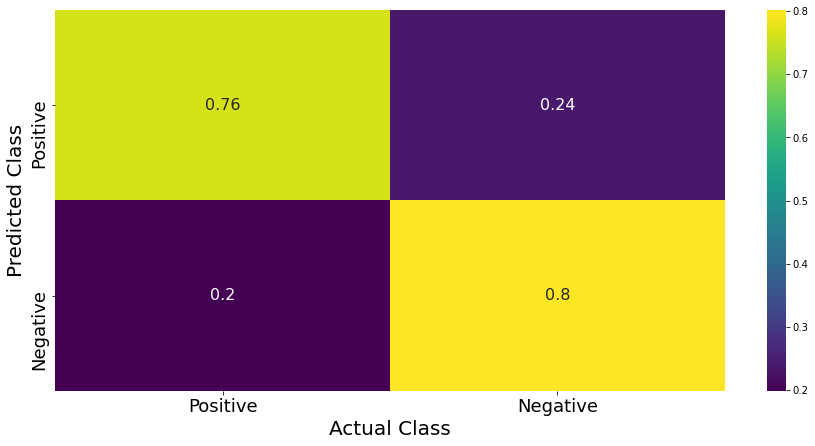

In [41]:
plt.rcParams['figure.figsize'] = [15, 7]
res = sns.heatmap(confusion_matrix(y_test,y_pred, normalize = 'true'), 
            annot = True, 
            xticklabels = ['Positive', 'Negative'],
            yticklabels = ['Positive', 'Negative'],
            cmap = 'viridis', annot_kws={"size": 16})

plt.xlabel('Actual Class', size = 20)
plt.ylabel('Predicted Class', size = 20)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)

In [42]:
DT = DecisionTreeClassifier(max_depth = 1000)
DT.fit(x_train, y_train)
y_pred = DT.predict(x_test)
print('accuracy: ', accuracy_score(y_test, y_pred))

accuracy:  0.733


In [43]:
from sklearn.ensemble import AdaBoostClassifier as boost

bc = boost(n_estimators = 50)

bc.fit(x_train,y_train)

y_pred = bc.predict(x_test.values)
print('accuracy: ', accuracy_score(y_test, y_pred))

accuracy:  0.822


In [44]:
probs = bc.predict_proba(x_test)

preds = probs[:,1]

fp, tp, thresh = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fp, tp)

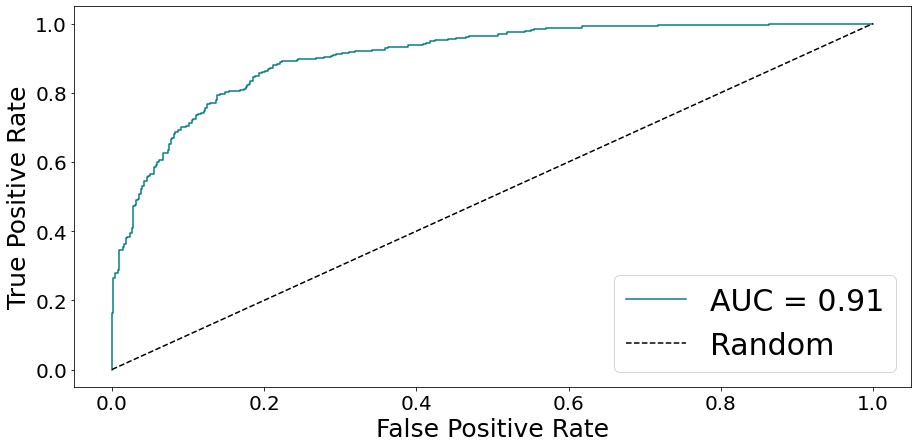

In [45]:
plt.plot(fp, tp, 'teal', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0,1],[0,1], 'black', linestyle = '--', label = 'Random')
plt.xlabel('False Positive Rate', size = 25)
plt.ylabel('True Positive Rate', size = 25)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)
plt.legend(fontsize = 30)

#### Task 4

In this task, you need to classify the above movie review dataset using a Support Vector Machine (SVM).

This task is worth 20 points out of 100 points. You are allowed to use existing library functions such as scikit-learn for obtaining the SVM. The main idea is to analyse the dataset using different kind of kernels. You are also supposed to write your own custom text kernels. The marking will be 10 marks for analysing the dataset using various kernels including your own kernels, 5 points for the performance on the test dataset and 5 points for a lab-report that provides the analysis and comparisons.

In [46]:
t1 = time.time()
# your code for svm based training of the dataset
sc = SVMClassifier(kernel = 'exponential',
                       reg_param = 1.0,
                       degree = 3,
                       max_iter = 1e3,
                       tol = 1e-3)

sc.fit_text(x_train.values, y_train)
y_pred = sc.predict_text(x_test.values)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Time: {} seconds'.format(time.time() - t1))

Accuracy: 0.858
Time: 139.6383991241455 seconds


[Text(0.5, 0, 'Positive'), Text(1.5, 0, 'Negative')]

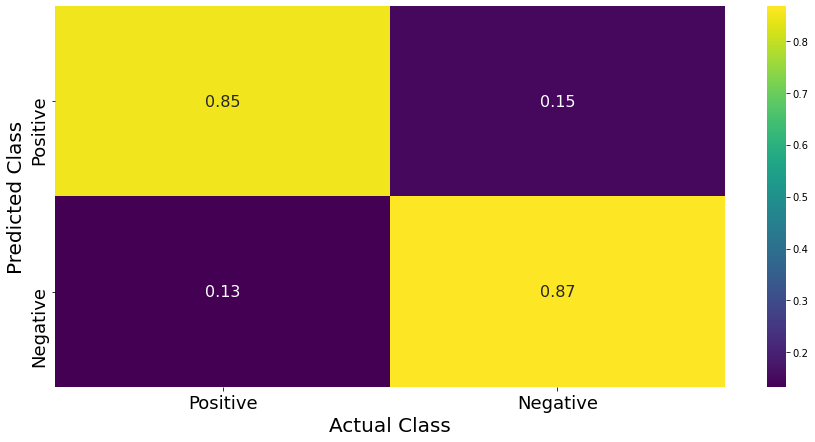

In [47]:
plt.rcParams['figure.figsize'] = [15, 7]
res = sns.heatmap(confusion_matrix(y_test,y_pred, normalize = 'true'), 
            annot = True, 
            xticklabels = ['Positive', 'Negative'],
            yticklabels = ['Positive', 'Negative'],
            cmap = 'viridis', annot_kws={"size": 16})

plt.xlabel('Actual Class', size = 20)
plt.ylabel('Predicted Class', size = 20)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)

# Cross Validation

In [48]:
scores = kfoldCV(df_pca, kfolds = 5, model_type = 'svm',
                   k = 'exponential',
                   reg = 1,
                   deg = 3)

print('Average score from Cross Validation: {:.2f}'.format(np.mean(scores)))

Fold:  4
Average score from Cross Validation: 0.85


## Comparing various kernel performance on sentiment classification

In [49]:
# test each kernel with CV and plot performance


kernels = sc.kernels_list() + ['intersection']
accuracy = []
for k in tqdm(kernels):
    
    # run CV on model
    sc = SVMClassifier(kernel = k,
                       reg_param = 1.0,
                       degree = 3,
                       max_iter = 1e3,
                       tol = 1e-3)

    sc.fit_text(x_train.values, y_train)
    y_pred = sc.predict_text(x_test.values)
    accuracy.append(accuracy_score(y_test, y_pred))

 23%|██▎       | 3/13 [00:04<00:12,  1.22s/it]<ipython-input-25-80667e6d14ad>:64: RuntimeWarning: overflow encountered in exp
  return np.exp(np.linalg.norm(U-V) ** 2 / (2*sigma**2))
100%|██████████| 13/13 [27:45<00:00, 128.15s/it]


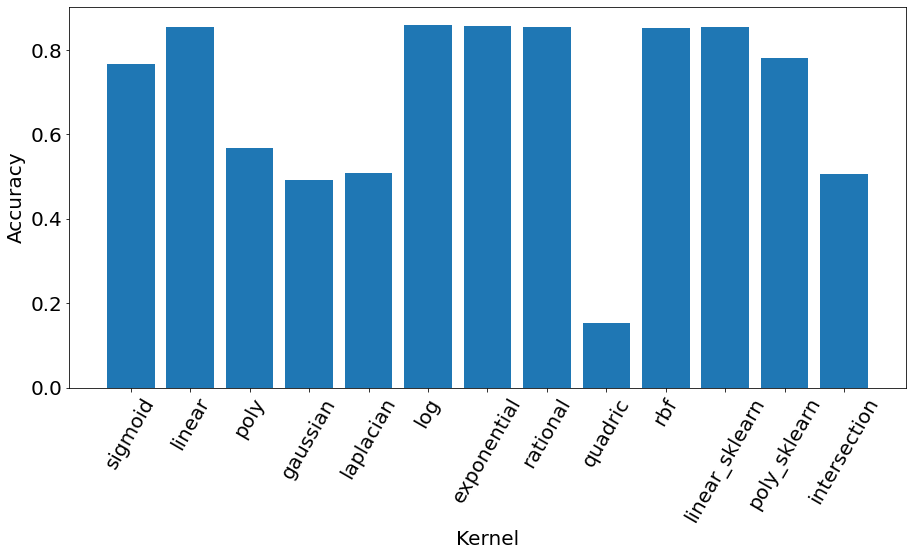

In [50]:
res = plt.bar(kernels, accuracy)
plt.xlabel('Kernel', size = 20)
plt.ylabel('Accuracy', size = 20)
plt.tick_params(axis='x', which='major', labelsize=20, rotation = 60)
plt.tick_params(axis='y', which='major', labelsize=20)

In [51]:
clf = svm.SVC(C = 2,
              kernel = 'rbf',
              degree = 3,
              gamma = 'scale')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print('accuracy: ', accuracy_score(y_test, y_pred))

accuracy:  0.857


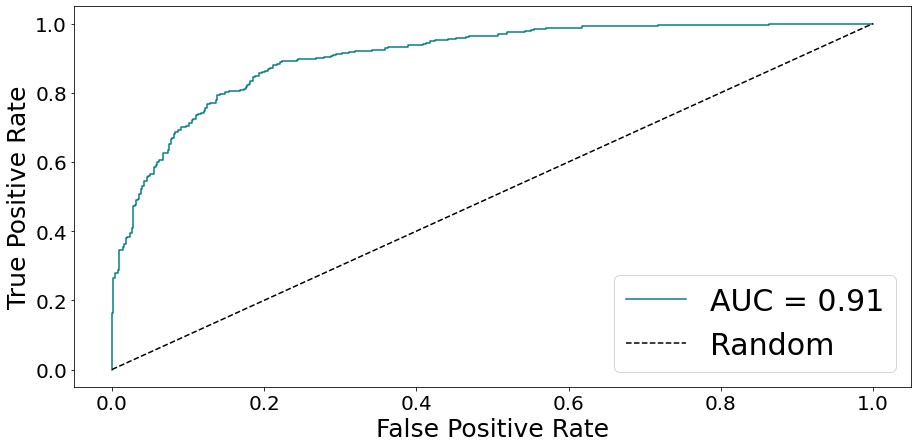

In [52]:
probs = bc.predict_proba(x_test)

preds = probs[:,1]

fp, tp, thresh = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fp, tp)

plt.plot(fp, tp, 'teal', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0,1],[0,1], 'black', linestyle = '--', label = 'Random')
plt.xlabel('False Positive Rate', size = 25)
plt.ylabel('True Positive Rate', size = 25)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)
plt.legend(fontsize = 30)